# Platoon Finding

This document aims to demonstrate the "platoon" phenomenon in a portion of the WIM data. Using years 2014-2016 in the Cereni station. 

In [1]:
import pandas as pd

In [22]:
df = pd.read_csv('CeneriData/2014_2016_datetime.csv', index_col=0, parse_dates=['Date'], dtype={'MMSS': 'str'})

C:\Users\Isabelle\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [23]:
df.keys()

Index(['ZST', 'FS', 'HHMMSS', 'CS', 'T', 'HH', 'MMSS', 'MM', 'Date'], dtype='object')

In [24]:
df.head()

,ZST,FS,HHMMSS,CS,T,HH,MMSS,MM,Date
0,408,4,2112,8,0,0,2112,21,2014-01-01
1,408,3,5554,3,0,0,5554,55,2014-01-01
2,408,3,10333,3,0,1,0333,3,2014-01-01
3,408,4,14034,10,0,1,4034,40,2014-01-01
4,408,4,15724,1,0,1,5724,57,2014-01-01


In [25]:
df.head()

,ZST,FS,HHMMSS,CS,T,HH,MMSS,MM,Date
0,408,4,2112,8,0,0,2112,21,2014-01-01
1,408,3,5554,3,0,0,5554,55,2014-01-01
2,408,3,10333,3,0,1,0333,3,2014-01-01
3,408,4,14034,10,0,1,4034,40,2014-01-01
4,408,4,15724,1,0,1,5724,57,2014-01-01


Turn the Date into a datetime that also uses the hours, minutes and seconds.

In [26]:
df.dtypes

ZST                int64
FS                 int64
HHMMSS             int64
CS                 int64
T                  int64
HH                 int64
MMSS              object
MM                 int64
Date      datetime64[ns]
dtype: object

In [27]:
df['Date'] += pd.to_timedelta(df.HH, unit='h')
df['Date'] += pd.to_timedelta(df.MM, unit='m')
df['SS'] = df['MMSS'].str[-2:]
df['SS'] = df['SS'].astype(int)
df['Date'] += pd.to_timedelta(df.SS, unit='s')

In [28]:
df.head(100)

,ZST,FS,HHMMSS,CS,T,HH,MMSS,MM,Date,SS
0,408,4,2112,8,0,0,2112,21,2014-01-01 00:21:12,12
1,408,3,5554,3,0,0,5554,55,2014-01-01 00:55:54,54
2,408,3,10333,3,0,1,0333,3,2014-01-01 01:03:33,33
3,408,4,14034,10,0,1,4034,40,2014-01-01 01:40:34,34
4,408,4,15724,1,0,1,5724,57,2014-01-01 01:57:24,24
...,...,...,...,...,...,...,...,...,...,...
95,408,4,152018,1,0,15,2018,20,2014-01-01 15:20:18,18
96,408,4,152259,1,0,15,2259,22,2014-01-01 15:22:59,59
97,408,4,152458,3,0,15,2458,24,2014-01-01 15:24:58,58
98,408,4,153636,10,0,15,3636,36,2014-01-01 15:36:36,36


In [29]:
df = df.set_index('Date')

In [30]:
df = df.sort_index()

In [33]:
df.rolling('30s').count()

AttributeError: 'DataFrame' object has no attribute 'unique'

In [34]:
df['FS'].unique()

array([4, 2, 3, 1], dtype=int64)

In [38]:
df_1 = df.loc[df['FS'].isin([3,4])]

In [39]:
df_2 = df.loc[df['FS'].isin([1,2])]

In [41]:
df_2.shape

(2101716, 9)

In [46]:
df_1_roll = df_1.rolling('30s').ZST.count()

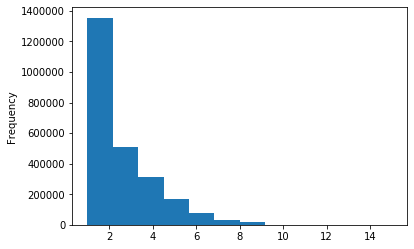

In [51]:
df_1_roll.plot.hist(bins=12)

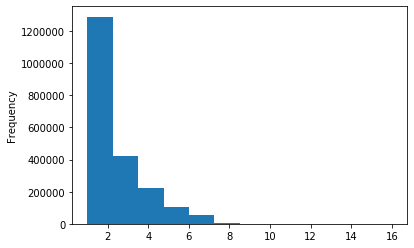

In [52]:
df_2_roll = df_2.rolling('30s').ZST.count()
df_2_roll.plot.hist(bins=12)